# Global Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import read_csv
import math, collections
from tensorflow import keras
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, ConvLSTM2D, Conv1D, Conv2D, Dropout, MaxPooling2D, MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import io
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.metrics import RootMeanSquaredError
debug = True
useGPU = True

# Setup the GPU

In [2]:
# used to load and test for a GPU
if useGPU:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import the Data

In [3]:
data = io.loadmat('data.mat')
data = data["Data"]
labels = np.loadtxt('label.csv', delimiter="\n", dtype=int)

# Fix the unbalanced data with oversampling

In [4]:
random_over_sampler = RandomOverSampler(random_state=1337)
data, labels = random_over_sampler.fit_resample(data,labels)
labels = np.array(np.ravel(labels))

# Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)
y_train = np.array(y_train)
num_classes = len(np.unique(y_train))

## Reshape the dataset

In [6]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

# The MLP Model

In [7]:
print (X_train.shape)
print (X_test.shape)

(280, 1, 3000)
(94, 1, 3000)


## Define the base model

In [8]:
# to use GPU with tf.device('/device:GPU:0'):

mlp_model = Sequential()
mlp_model.add(Dense(600, input_shape=(None,3000),activation='relu'))
mlp_model.add(Dense(500, activation='relu'))
mlp_model.add(Dense(400, activation='relu'))
mlp_model.add(Dense(300, activation='relu'))
mlp_model.add(Dense(200, activation='relu'))
mlp_model.add(Dense(100, activation='relu'))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dense(25, activation='relu'))
mlp_model.add(Dense(10, activation='relu'))
mlp_model.add(Dense(1))



## Compile the model

In [9]:
mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 600)         1800600   
                                                                 
 dense_1 (Dense)             (None, None, 500)         300500    
                                                                 
 dense_2 (Dense)             (None, None, 400)         200400    
                                                                 
 dense_3 (Dense)             (None, None, 300)         120300    
                                                                 
 dense_4 (Dense)             (None, None, 200)         60200     
                                                                 
 dense_5 (Dense)             (None, None, 100)         20100     
                                                                 
 dense_6 (Dense)             (None, None, 50)          5

## The Callback for ealry stopapge

In [10]:
callback_mlp = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=15, verbose=1),
]

## Train the MLP Model

In [11]:
before_mlp = datetime.utcnow()
print ("Start time (UTC): "+str(before_mlp))
with tf.device('/device:GPU:0'):
    # fit the model
  mlp_history = mlp_model.fit(X_train, y_train, epochs=250, 
            verbose=1, 
            workers=8, # multithread
            callbacks=callback_mlp, 
            validation_data=(X_test,y_test),
            use_multiprocessing=True) # multithread
# get the stop time
after_mlp = datetime.utcnow()
print ("Stop Time (UTC): "+str(after_mlp))

# do the math for the time difference
print ("Run time: "+str(after_mlp-before_mlp))

Start time (UTC): 2022-04-13 01:08:30.282910
Epoch 1/250
9/9 [==============================] - 4s 50ms/step - loss: 0.3306 - accuracy: 0.5188 - mean_squared_error: 0.3306 - root_mean_squared_error: 0.5748 - val_loss: 0.2662 - val_accuracy: 0.4958 - val_mean_squared_error: 0.2662 - val_root_mean_squared_error: 0.5161
Epoch 2/250
9/9 [==============================] - 0s 11ms/step - loss: 0.2683 - accuracy: 0.4902 - mean_squared_error: 0.2683 - root_mean_squared_error: 0.5181 - val_loss: 0.2635 - val_accuracy: 0.4958 - val_mean_squared_error: 0.2635 - val_root_mean_squared_error: 0.5134
Epoch 3/250
9/9 [==============================] - 0s 9ms/step - loss: 0.2612 - accuracy: 0.5122 - mean_squared_error: 0.2612 - root_mean_squared_error: 0.5114 - val_loss: 0.2778 - val_accuracy: 0.4750 - val_mean_squared_error: 0.2778 - val_root_mean_squared_error: 0.5275
Epoch 4/250
9/9 [==============================] - 0s 9ms/step - loss: 0.2781 - accuracy: 0.4942 - mean_squared_error: 0.2781 - root_m

# The CNN Model

## Define the Model

In [12]:
# to use GPU with tf.device('/device:GPU:0'):
cnn_model = Sequential()
cnn_model.add(Conv1D(256, (1), activation='relu', input_shape=(None, 3000)))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(128, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(64, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(32, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(16, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(8, (1), activation='relu'))
cnn_model.add(Dense(1))

## Compile the Model

In [13]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 256)         768256    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 256)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         32896     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          8256      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)        

## The Callback for early stoppage

In [ ]:
callback_cnn = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the CNN Model

In [14]:
before_cnn = datetime.utcnow()
print ("Start time (UTC): "+str(before_cnn))
with tf.device('/device:GPU:0'):
    # fit the model
  cnn_history = cnn_model.fit(X_train, y_train, epochs=10000, 
            verbose=1, 
            workers=8, # multithread
            #callbacks=callback_cnn, 
            validation_data=(X_test,y_test),
            use_multiprocessing=True) # multithread
# get the stop time
after_cnn = datetime.utcnow()
print ("Stop Time (UTC): "+str(after_cnn))

# do the math for the time difference
print ("Run time: "+str(after_cnn-before_cnn))

Streaming output truncated to the last 5000 lines.
Epoch 7502/10000
9/9 [==============================] - 0s 14ms/step - loss: 0.2502 - accuracy: 0.5107 - mean_squared_error: 0.2502 - root_mean_squared_error: 0.5002 - val_loss: 0.2505 - val_accuracy: 0.4681 - val_mean_squared_error: 0.2505 - val_root_mean_squared_error: 0.5006
Epoch 7503/10000
9/9 [==============================] - 0s 14ms/step - loss: 0.2499 - accuracy: 0.5107 - mean_squared_error: 0.2499 - root_mean_squared_error: 0.4999 - val_loss: 0.2509 - val_accuracy: 0.4681 - val_mean_squared_error: 0.2509 - val_root_mean_squared_error: 0.5009
Epoch 7504/10000
9/9 [==============================] - 0s 13ms/step - loss: 0.2499 - accuracy: 0.5107 - mean_squared_error: 0.2499 - root_mean_squared_error: 0.5000 - val_loss: 0.2507 - val_accuracy: 0.4681 - val_mean_squared_error: 0.2507 - val_root_mean_squared_error: 0.5008
Epoch 7505/10000
9/9 [==============================] - 0s 13ms/step - loss: 0.2499 - accuracy: 0.5107 - mean_sq

# The LSTM Model

## Define the model

In [ ]:
seq_size=3000
lstm_model=Sequential()
lstm_model.add(LSTM(50,activation='relu', return_sequences=True, input_shape=(None,seq_size)))
lstm_model.add(LSTM(50,activation='relu'))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(1))

## Compile the model

In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])

## The callback for early stoppage

In [ ]:
callback_lstm = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the LSTM Model

In [ ]:
# to use GPU with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
  before_lstm = datetime.utcnow()
  print ("Start time (UTC): "+str(before_lstm))
  with tf.device('/device:GPU:0'):
      # fit the model
    lstm_history = lstm_model.fit(X_train, y_train, epochs=250, 
              verbose=1, 
              workers=8, # multithread
              callbacks=callback_lstm, 
              validation_data=(X_test,y_test),
              use_multiprocessing=True) # multithread
  # get the stop time
  after_lstm = datetime.utcnow()
  print ("Stop Time (UTC): "+str(after_lstm))

  # do the math for the time difference
  print ("Run time: "+str(after_lstm-before_lstm))

Start time (UTC): 2022-04-13 01:05:10.489706
Epoch 1/250
9/9 [==============================] - 3s 58ms/step - loss: 0.3440 - accuracy: 0.4964 - mean_squared_error: 0.3440 - root_mean_squared_error: 0.5865 - val_loss: 0.2574 - val_accuracy: 0.4894 - val_mean_squared_error: 0.2574 - val_root_mean_squared_error: 0.5073
Epoch 2/250
9/9 [==============================] - 0s 15ms/step - loss: 0.2777 - accuracy: 0.4500 - mean_squared_error: 0.2777 - root_mean_squared_error: 0.5270 - val_loss: 0.2554 - val_accuracy: 0.5106 - val_mean_squared_error: 0.2554 - val_root_mean_squared_error: 0.5054
Epoch 3/250
9/9 [==============================] - 0s 12ms/step - loss: 0.2506 - accuracy: 0.5107 - mean_squared_error: 0.2506 - root_mean_squared_error: 0.5006 - val_loss: 0.2570 - val_accuracy: 0.4894 - val_mean_squared_error: 0.2570 - val_root_mean_squared_error: 0.5070
Epoch 4/250
9/9 [==============================] - 0s 12ms/step - loss: 0.2499 - accuracy: 0.5214 - mean_squared_error: 0.2499 - root

# The VGG16 Model

## Define the Model

## Compile the Model

## The callback for early stoppage

## Train the VGG16 Model

# Plot the Metrics

## The base plot function

In [16]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot Metrics code from here https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss','mean_squared_error','accuracy','root_mean_squared_error']
  print (metrics)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Training Data')

    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend();


## Metrics for CNN

['loss', 'mean_squared_error', 'accuracy', 'root_mean_squared_error']


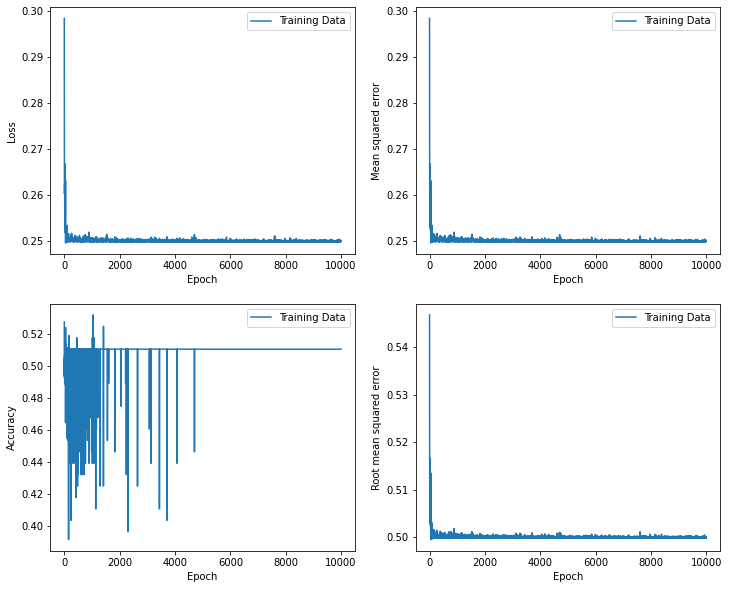

In [17]:
plot_metrics(cnn_history)


## Do the math for metrics

In [ ]:
# Loss
## Min
print ("CNN Loss Min")
## Max
print ("CNN Loss Max")
## Avg
print ("CNN Loss Avg")
#SCC
## Min
print ("CNN SCC Min")
## Max
print ("CNN SCC Max")
## Avg
print ("CNN SCC Avg")
# Acc
## Min
print ("CNN Acc Min")
## Max
print ("CNN Acc Max")
## Avg
print ("CNN Acc Max")

CNN Loss Min
CNN Loss Max
CNN Loss Avg
CNN SCC Min
CNN SCC Max
CNN SCC Avg
CNN Acc Min
CNN Acc Max
CNN Acc Max


## Mertric for MLP

['loss', 'mean_squared_error', 'accuracy', 'root_mean_squared_error']


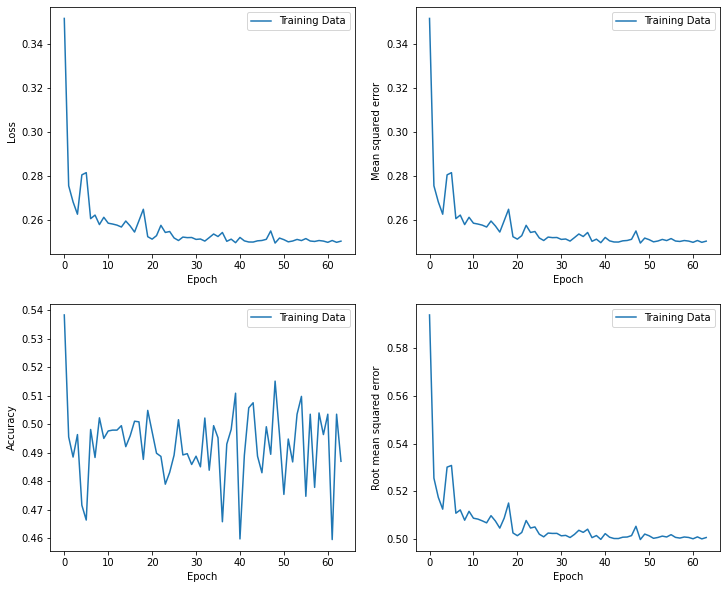

In [ ]:
plot_metrics(mlp_history)


## Do the math for metrics

In [ ]:
# Loss
## Min
## Max
## Avg

#SCC
## Min
## Max
## Avg

# Acc
## Min
## Max
## Avg

## Metrics for LSTM

['loss', 'mean_squared_error', 'accuracy', 'root_mean_squared_error']


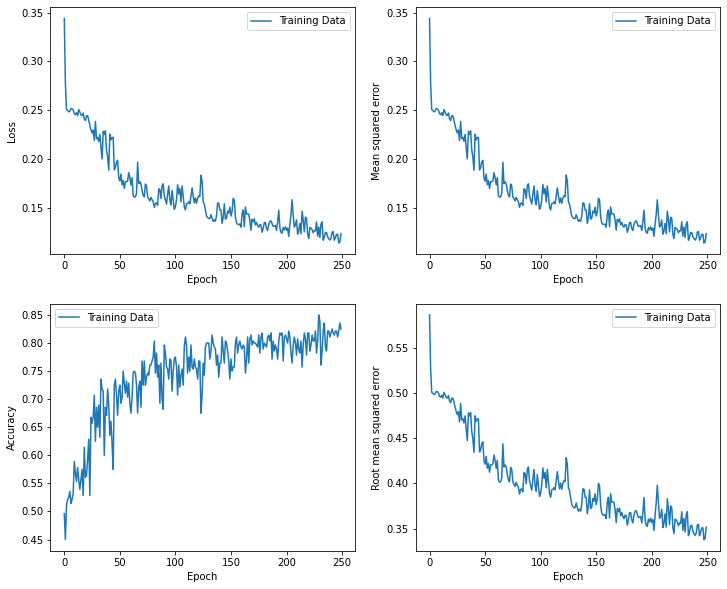

In [ ]:
plot_metrics(lstm_history)


## Do the math for metrics

In [ ]:
# Loss
## Min
## Max
## Avg

#SCC
## Min
## Max
## Avg

# Acc
## Min
## Max
## Avg

## Metrics for VGG16